In [20]:
import torch
from torch import nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [21]:
TARGET = 'percentage_docks_available'
SEQUENCE_LENGTH = 4
BATCH_SIZE = 16384*2

In [22]:
df = pd.read_csv('../datasets/train_dataset.csv')

In [23]:
df = df[df.status == 1]
assert df[(df.is_renting != 1) & (df.is_installed != 1)].shape[0] == 0

In [24]:
cols = [col for col in df.columns if 'ctx' in col]

In [25]:
df = df[cols + [TARGET]]

In [26]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

In [27]:
y_train, y_test = df_train.pop(TARGET), df_test.pop(TARGET)

## LSTM

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [29]:
class BicingDataset(Dataset):

    def __init__(self, X, y):

        self.x_train = torch.tensor(X.values.astype('float32'), dtype=torch.float32).reshape(-1, SEQUENCE_LENGTH, 1).to(device)
        self.y_train = torch.tensor(y.values.astype('float32'), dtype = torch.float32).view(-1,1).to(device)

    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

In [30]:
train_ds = BicingDataset(df_train, y_train)
test_ds = BicingDataset(df_test, y_test)

In [31]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle = False)

In [32]:
class LSTM(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(X, (h0, c0))
        out = out[:, -1, :]
        out = self.fc(out)
        return out
        

In [33]:
def compute_rmse(predictions: torch.tensor, targets: torch.tensor):

    error = predictions - targets
    squared_error = torch.pow(error, 2)
    mean_squared_error = torch.mean(squared_error)
    rmse = torch.sqrt(mean_squared_error)
    return rmse.item()

In [34]:
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss = 0
    train_rmse = 0

    for batch, (X, y) in enumerate(loader):
        X,y = X.to(device), y.to(device)

        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_rmse += compute_rmse(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    train_loss = train_loss / len(loader)
    train_rmse = train_rmse / len(loader)

    return train_loss, train_rmse

        

In [35]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [36]:
def test_step(model: torch.nn.Module,
               loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:
    
    model.eval()

    test_loss, test_rmse = 0, 0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(loader):
            X,y = X.to(device), y.to(device)

            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_rmse += compute_rmse(test_pred, y)
        
        test_loss = test_loss / len(loader)
        test_rmse = test_rmse / len(loader)

        return test_loss, test_rmse



        

In [37]:
def train(model: torch.nn.Module, 
          train_loader: torch.utils.data.DataLoader, 
          test_loader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          early_stopping: EarlyStopper = None) -> Dict[str, List]:
  

  history = {
      'train_loss': [],
      'train_rmse': [],
      'test_loss': [],
      'test_rmse': []
  }

  model.to(device)

  for epoch in range(epochs):
      train_loss, train_rmse = train_step(model=model,
                                          loader= train_loader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      
      test_loss, test_rmse = test_step(model=model,
                                          loader= test_loader,
                                          loss_fn=loss_fn,
                                          device=device)
      
      print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_rmse: {train_rmse:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_rmse: {test_rmse:.4f}"
      )

      history["train_loss"].append(train_loss)
      history["train_rmse"].append(train_rmse)
      history["test_loss"].append(test_loss)
      history["test_rmse"].append(test_rmse)
      if early_stopping:
        if early_stopping.early_stop(test_loss):
          break

  return history

In [38]:
LEARNING_RATE = 0.001
INPUT_SIZE = 1
hidden_size = 16
num_layers = 3
OUTPUT_SIZE = 1
EPOCHS = 10

model = LSTM(INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
model.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

history = train(model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            loss_fn = loss,
            device = device,
            epochs = EPOCHS,
            early_stopping=EarlyStopper(patience=1, min_delta=0.001))

Epoch: 1 | train_loss: 0.1294 | train_rmse: 0.3519 | test_loss: 0.0738 | test_rmse: 0.2717
Epoch: 2 | train_loss: 0.0673 | train_rmse: 0.2594 | test_loss: 0.0579 | test_rmse: 0.2406
Epoch: 3 | train_loss: 0.0424 | train_rmse: 0.2052 | test_loss: 0.0357 | test_rmse: 0.1888
Epoch: 4 | train_loss: 0.0341 | train_rmse: 0.1848 | test_loss: 0.0319 | test_rmse: 0.1787
Epoch: 5 | train_loss: 0.0286 | train_rmse: 0.1691 | test_loss: 0.0237 | test_rmse: 0.1539
Epoch: 6 | train_loss: 0.0184 | train_rmse: 0.1352 | test_loss: 0.0146 | test_rmse: 0.1206
Epoch: 7 | train_loss: 0.0134 | train_rmse: 0.1159 | test_loss: 0.0126 | test_rmse: 0.1124
Epoch: 8 | train_loss: 0.0127 | train_rmse: 0.1125 | test_loss: 0.0125 | test_rmse: 0.1119
Epoch: 9 | train_loss: 0.0126 | train_rmse: 0.1122 | test_loss: 0.0125 | test_rmse: 0.1117
Epoch: 10 | train_loss: 0.0126 | train_rmse: 0.1121 | test_loss: 0.0125 | test_rmse: 0.1116


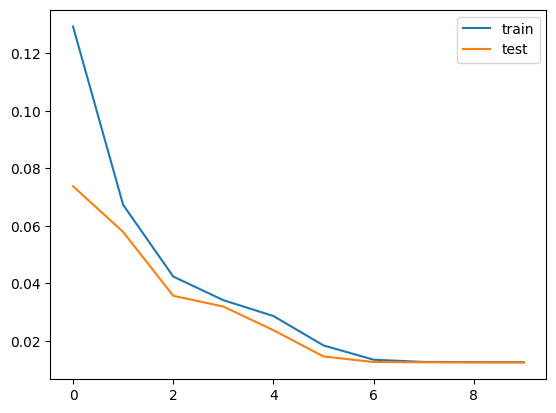

In [39]:
plt.figure()
plt.plot(history.get('train_loss'), label = 'train')
plt.plot(history.get('test_loss'), label = 'test')
plt.legend()

## RNN

In [40]:
class RNN(nn.Module):

    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first = True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(self.num_layers, X.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(X, h0)
        out = out[:, -1, :]
        out = self.fc(out)
        return out
        

In [41]:
LEARNING_RATE = 0.001
INPUT_SIZE = 1
hidden_size = 16
num_layers = 3
OUTPUT_SIZE = 1
EPOCHS = 6

model = RNN(INPUT_SIZE, hidden_size, num_layers, OUTPUT_SIZE)
model.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

history = train(model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            loss_fn = loss,
            device = device,
            epochs = EPOCHS,
            early_stopping=EarlyStopper(patience=0, min_delta=0.001))

Epoch: 1 | train_loss: 0.0427 | train_rmse: 0.2030 | test_loss: 0.0234 | test_rmse: 0.1528
Epoch: 2 | train_loss: 0.0191 | train_rmse: 0.1380 | test_loss: 0.0156 | test_rmse: 0.1250
Epoch: 3 | train_loss: 0.0141 | train_rmse: 0.1189 | test_loss: 0.0129 | test_rmse: 0.1135
Epoch: 4 | train_loss: 0.0128 | train_rmse: 0.1130 | test_loss: 0.0126 | test_rmse: 0.1123
Epoch: 5 | train_loss: 0.0127 | train_rmse: 0.1127 | test_loss: 0.0126 | test_rmse: 0.1122
Epoch: 6 | train_loss: 0.0127 | train_rmse: 0.1127 | test_loss: 0.0126 | test_rmse: 0.1122


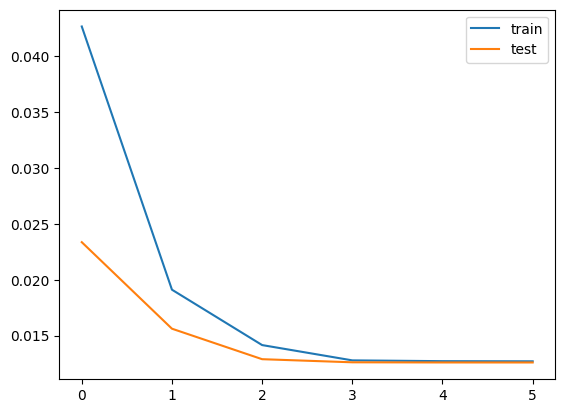

In [42]:
plt.figure()
plt.plot(history.get('train_loss'), label = 'train')
plt.plot(history.get('test_loss'), label = 'test')
plt.legend()

## Hybrid model

In [43]:
df = pd.read_csv('../datasets/train_dataset.csv')
df = df[df.status == 1]
assert df[(df.is_renting != 1) & (df.is_installed != 1)].shape[0] == 0

In [44]:
ctx_cols = [col for col in df.columns if 'ctx' in col]

In [45]:
std_cols = ['lat', 'lon']
minmax_cols = ['altitude', 'temp', 'humidity']
ohe_cols = ['dayofweek', 'season']

In [46]:
fc_cols = ['season', 'altitude', 'temp', 'humidity', 'lat', 'lon', 'dayofweek', 'sin_time', 'cos_time']

In [47]:
useful_cols = ctx_cols + fc_cols + [TARGET]

In [48]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

class pdOneHotEncoder(OneHotEncoder):
    def __init__(self, cols: list):
        super().__init__(sparse_output = False)
        self.cols = cols
        
    def fit(self, X, y):
        super().fit(X[self.cols],y)
        return self
    
    def transform(self, X, y = None):
        X_ = X.copy()
        X_oh = super().transform(X_[self.cols])
        feature_names = self.get_feature_names_out()
        X_encoded = pd.DataFrame(X_oh, columns=feature_names, index=X_.index)
        X_ = pd.concat([X_, X_encoded], axis=1)
        X_ = X_.drop(self.cols, axis=1)
        return X_
    
class focusMinMaxScaler(MinMaxScaler):
    def __init__(self, cols:list):
        super().__init__()
        self.cols = cols
    def fit(self,X,y):
        super().fit(X[self.cols],y)
        return self
    def transform(self, X):
        X_ = X.copy()
        X_[self.cols] = super().transform(X_[self.cols])
        return X_
    
class focusStandardScaler(StandardScaler):
    def __init__(self, cols:list):
        super().__init__()
        self.cols = cols
    def fit(self,X,y):
        super().fit(X[self.cols],y)
        return self
    def transform(self, X):
        X_ = X.copy()
        X_[self.cols] = super().transform(X_[self.cols])
        return X_

In [49]:
def month_to_season(row):
    if row.month in [12,1,2]:
        return 'winter'
    elif row.month in [3, 4, 5]:
        return 'spring'
    elif row.month in [6,7,8]:
        return 'summer'
    elif row.month in [9,10,11]:
        return 'fall'
    else:
        raise ValueError('value outside of range 1-12')

In [51]:
def hour_to_polar(df):
    data = df.copy()
    data['sin_time'] = np.sin(data.hour)
    data['cos_time'] = np.cos(data.hour)
    return data

In [89]:
useful_cols

['ctx-4',
 'ctx-3',
 'ctx-2',
 'ctx-1',
 'season',
 'altitude',
 'temp',
 'humidity',
 'lat',
 'lon',
 'dayofweek',
 'sin_time',
 'cos_time',
 'percentage_docks_available']

In [91]:
def preprocess(df, test = False):
    data = df.copy()
    data = hour_to_polar(data)
    data['season'] = data.apply(month_to_season, axis = 1)
    if test:
        return data[[col for col in useful_cols if col != TARGET]]
    return data[useful_cols]
    

In [53]:
df = preprocess(df)

In [54]:
df_train, df_test = train_test_split(df, test_size=0.3, shuffle=True, random_state=42)

In [55]:
y_train = df_train.pop(TARGET)
y_test = df_test.pop(TARGET)

In [56]:
pipe = Pipeline([
    ('ohe', pdOneHotEncoder(cols = ohe_cols)),
    ('mms', focusMinMaxScaler(cols = minmax_cols)),
    ('std_cols', focusStandardScaler(cols = std_cols))
])

In [57]:
pipe.fit(df_train, y_train)
df_train_proc = pipe.transform(df_train)
df_test_proc = pipe.transform(df_test)

In [58]:
non_seq_cols = [col for col in df_train_proc.columns if 'ctx' not in col]

In [163]:
class HybridDataset(Dataset):

    def __init__(self, X, y):

        self.x_seq = torch.tensor(X[ctx_cols].values.astype('float32'), dtype=torch.float32).reshape(-1, SEQUENCE_LENGTH, 1).to(device)
        self.x_fc = torch.tensor(X[non_seq_cols].values.astype('float32'), dtype = torch.float32).to(device)
        self.y = torch.tensor(y.values.astype('float32'), dtype = torch.float32).view(-1,1).to(device)

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x_seq[idx], self.x_fc[idx], self.y[idx]

In [107]:
train_ds = HybridDataset(df_train_proc, y_train)

In [108]:
test_ds = HybridDataset(df_test_proc, y_test)

In [109]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle = True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle = False)

In [110]:
x_seq = torch.tensor(df_train_proc[ctx_cols].values.astype('float32'), dtype=torch.float32).reshape(-1, SEQUENCE_LENGTH, 1).to(device)
x_fc = torch.tensor(df_train_proc[non_seq_cols].values.astype('float32'), dtype = torch.float32).to(device)

In [111]:
x_seq.shape, x_fc.shape

(torch.Size([1692840, 4, 1]), torch.Size([1692840, 18]))

In [112]:
# class HybridLSTM(nn.Module):
#     def __init__(self, input_size_seq, hidden_size, num_layers, input_size_features, output_size):
#         super().__init__()

#         self.sequence_lstm = nn.LSTM(input_size_seq, hidden_size, num_layers, batch_first=True)
#         self.fc_features = nn.Linear(input_size_features, hidden_size)
#         self.fc_concat = nn.Linear(hidden_size * 2, hidden_size) 
#         self.fc_output = nn.Linear(hidden_size, output_size)

#     def forward(self, sequence_input, feature_input):
#         sequence_output, _ = self.sequence_lstm(sequence_input)  
#         feature_output = F.selu(self.fc_features(feature_input))
#         concatenated = torch.cat((sequence_output[:, -1, :], feature_output), dim=1)
#         concatenated = F.relu(self.fc_concat(concatenated))

#         output = self.fc_output(concatenated)
#         return output

class HybridLSTM(nn.Module):
    def __init__(self, input_size_seq, hidden_size, num_layers, input_size_features, output_size):
        super(HybridLSTM, self).__init__()

        self.sequence_lstm = nn.LSTM(input_size_seq, hidden_size, num_layers, batch_first=True)
        self.fc_features1 = nn.Linear(input_size_features, hidden_size)
        # self.bn1 = nn.BatchNorm1d(hidden_size)
        self.dropout1 = nn.Dropout(0.4)
        self.fc_features2 = nn.Linear(hidden_size, hidden_size * 2)  
        self.fc_concat = nn.Linear(hidden_size * 3, hidden_size) 
        self.dropout2 = nn.Dropout(0.2)
        self.fc_output = nn.Linear(hidden_size, output_size)

    def forward(self, sequence_input, feature_input):
        sequence_output, _ = self.sequence_lstm(sequence_input)
        feature_output = F.relu(self.fc_features1(feature_input))
        # feature_output = self.bn1(feature_output)
        feature_output = self.dropout1(feature_output)
        feature_output = F.relu(self.fc_features2(feature_output))
        concatenated = torch.cat((sequence_output[:, -1, :], feature_output), dim=1)
        concatenated = self.dropout2(concatenated)
        concatenated = F.relu(self.fc_concat(concatenated))

        output = self.fc_output(concatenated)
        return output

In [172]:
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    
    model.train()
    train_loss = 0
    train_rmse = 0

    for batch, (X_seq, X_fc, y) in enumerate(loader):
        X_seq, X_fc,y = X_seq.to(device), X_fc.to(device), y.to(device)
        y_pred = model(X_seq, X_fc)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        train_rmse += compute_rmse(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    train_loss = train_loss / len(loader)
    train_rmse = train_rmse / len(loader)

    return train_loss, train_rmse


def test_step(model: torch.nn.Module,
               loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device) -> Tuple[float, float]:
    
    model.eval()

    test_loss, test_rmse = 0, 0
    with torch.inference_mode():
        for batch, (X_seq, X_fc, y) in enumerate(loader):
            X_seq, X_fc,y = X_seq.to(device), X_fc.to(device), y.to(device)

            test_pred = model(X_seq, X_fc)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_rmse += compute_rmse(test_pred, y)
        
        test_loss = test_loss / len(loader)
        test_rmse = test_rmse / len(loader)

        return test_loss, test_rmse



def train(model: torch.nn.Module, 
          train_loader: torch.utils.data.DataLoader, 
          test_loader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          early_stopping: EarlyStopper = None,
          full_train: bool = False) -> Dict[str, List]:
  

    history = {
      'train_loss': [],
      'train_rmse': [],
      'test_loss': [],
      'test_rmse': []
    }

    model.to(device)

    for epoch in range(epochs):
        train_loss, train_rmse = train_step(model=model,
                                        loader= train_loader,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer,
                                        device=device)
        if not full_train:
            test_loss, test_rmse = test_step(model=model,
                                            loader= test_loader,
                                            loss_fn=loss_fn,
                                            device=device)
      
            print(
                f"Epoch: {epoch+1} | "
                f"train_loss: {train_loss:.4f} | "
                f"train_rmse: {train_rmse:.4f} | "
                f"test_loss: {test_loss:.4f} | "
                f"test_rmse: {test_rmse:.4f}"
            )

            history["train_loss"].append(train_loss)
            history["train_rmse"].append(train_rmse)
            history["test_loss"].append(test_loss)
            history["test_rmse"].append(test_rmse)
            if early_stopping:
                if early_stopping.early_stop(test_loss):
                    break
        else:
            print(
            f"train_loss: {train_loss:.4f} | "
            f"train_rmse: {train_rmse:.4f} | "
            )
            history["train_loss"].append(train_loss)
            history["train_rmse"].append(train_rmse)

    return history
        

In [74]:
LEARNING_RATE = 0.001
INPUT_SIZE_SEQ = 1
INPUT_SIZE_FEAT = 18
hidden_size = 16
num_layers = 2
OUTPUT_SIZE = 1
EPOCHS = 10

model = HybridLSTM(INPUT_SIZE_SEQ, hidden_size, num_layers, INPUT_SIZE_FEAT, OUTPUT_SIZE)
model.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

history = train(model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            optimizer=optimizer,
            loss_fn = loss,
            device = device,
            epochs = EPOCHS,
            early_stopping=EarlyStopper(patience=0, min_delta=0.001))

Epoch: 1 | train_loss: 0.1170 | train_rmse: 0.3347 | test_loss: 0.0709 | test_rmse: 0.2664
Epoch: 2 | train_loss: 0.0642 | train_rmse: 0.2529 | test_loss: 0.0420 | test_rmse: 0.2049
Epoch: 3 | train_loss: 0.0384 | train_rmse: 0.1958 | test_loss: 0.0327 | test_rmse: 0.1807
Epoch: 4 | train_loss: 0.0325 | train_rmse: 0.1801 | test_loss: 0.0251 | test_rmse: 0.1585
Epoch: 5 | train_loss: 0.0222 | train_rmse: 0.1486 | test_loss: 0.0154 | test_rmse: 0.1241
Epoch: 6 | train_loss: 0.0170 | train_rmse: 0.1305 | test_loss: 0.0134 | test_rmse: 0.1159
Epoch: 7 | train_loss: 0.0152 | train_rmse: 0.1234 | test_loss: 0.0126 | test_rmse: 0.1124
Epoch: 8 | train_loss: 0.0148 | train_rmse: 0.1217 | test_loss: 0.0124 | test_rmse: 0.1115
Epoch: 9 | train_loss: 0.0147 | train_rmse: 0.1210 | test_loss: 0.0125 | test_rmse: 0.1118
Epoch: 10 | train_loss: 0.0145 | train_rmse: 0.1204 | test_loss: 0.0126 | test_rmse: 0.1121


In [114]:
df = pd.read_csv('../datasets/train_dataset.csv')
df = df[df.status == 1]
assert df[(df.is_renting != 1) & (df.is_installed != 1)].shape[0] == 0

In [149]:
import calendar

test_df = pd.read_csv('../datasets/sub_dataset.csv', index_col=0)
test_df = test_df.sort_index()

march_2023_dict = {}
for day in range(1, 32):
    weekday = calendar.weekday(2023, 3, day)
    march_2023_dict[day] = weekday

test_df['dayofweek'] = test_df.day.map(march_2023_dict)

In [150]:
X = preprocess(df)
y = X.pop(TARGET)

In [151]:
X.head(2)

,ctx-4,ctx-3,ctx-2,ctx-1,season,altitude,temp,humidity,lat,lon,dayofweek,sin_time,cos_time
0,0.474638,0.507246,0.570652,0.617754,winter,16.0,39.4,88.17,41.397978,2.180107,2.0,-0.756802,-0.653644
1,0.324713,0.206897,0.037356,0.080460,winter,17.0,39.4,88.17,41.395488,2.177198,2.0,-0.756802,-0.653644


In [152]:
X_test = preprocess(test_df, test = True)

In [153]:
X_test.head(2)

,ctx-4,ctx-3,ctx-2,ctx-1,season,altitude,temp,humidity,lat,lon,dayofweek,sin_time,cos_time
index,,,,,,,,,,,,,
0,0.753086,0.780864,0.799383,0.824074,spring,25,41.6,79.20,41.387306,2.163126,1,0.989358,-0.145500
1,0.463768,0.536232,0.532609,0.601449,spring,117,63.8,64.73,41.398624,2.120494,3,-0.536573,0.843854


In [154]:
pipe.fit(X,y)
X_proc = pipe.transform(X)
X_test_proc = pipe.transform(X_test)

In [176]:
def prepare_test(data: pd.DataFrame) -> Tuple:
    X = data.copy()
    x_seq = torch.tensor(X[ctx_cols].values.astype('float32'), dtype=torch.float32).reshape(-1, SEQUENCE_LENGTH, 1).to(device)
    x_fc = torch.tensor(X[non_seq_cols].values.astype('float32'), dtype = torch.float32).to(device)
    return x_seq, x_fc

In [164]:
full_train_ds = HybridDataset(X_proc, y)

In [167]:
full_train_dl = DataLoader(full_train_ds, batch_size=BATCH_SIZE, shuffle = True)

In [173]:
LEARNING_RATE = 0.001
INPUT_SIZE_SEQ = 1
INPUT_SIZE_FEAT = 18
hidden_size = 16
num_layers = 2
OUTPUT_SIZE = 1
EPOCHS = 8

model = HybridLSTM(INPUT_SIZE_SEQ, hidden_size, num_layers, INPUT_SIZE_FEAT, OUTPUT_SIZE)
model.to(device)

loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

history = train(model=model,
            train_loader=train_loader,
            test_loader=None,
            optimizer=optimizer,
            loss_fn = loss,
            device = device,
            epochs = EPOCHS,
            early_stopping=EarlyStopper(patience=0, min_delta=0.001),
            full_train=True)

train_loss: 0.1375 | train_rmse: 0.3633 | 
train_loss: 0.0597 | train_rmse: 0.2437 | 
train_loss: 0.0371 | train_rmse: 0.1925 | 
train_loss: 0.0323 | train_rmse: 0.1797 | 
train_loss: 0.0244 | train_rmse: 0.1558 | 
train_loss: 0.0172 | train_rmse: 0.1310 | 
train_loss: 0.0149 | train_rmse: 0.1223 | 
train_loss: 0.0144 | train_rmse: 0.1201 | 


In [177]:
x_test_seq, x_test_fc = prepare_test(X_test_proc)
model.eval()

with torch.no_grad():
    y_pred = model(x_test_seq, x_test_fc)


In [180]:
sample_sub = pd.read_csv('../data/submission_data/sample_submission.csv')

In [186]:
y_pred.detach()

tensor([[0.7685],
        [0.5669],
        [0.5776],
        ...,
        [0.7142],
        [0.2233],
        [0.8309]], device='cuda:0')

In [189]:
sample_sub[TARGET] = y_pred.cpu()

In [191]:
sample_sub.to_csv('./submissions/hybridlstm.csv', index = None)